eldiario 0    18 julio, 2025
1    18 julio, 2025
2    18 julio, 2025
Name: fecha, dtype: object
0   2025-07-18
1   2025-07-18
2   2025-07-18
Name: fecha, dtype: datetime64[ns]
analisis: 0    20 de Julio de 2025 - 19:25
1    20 de Julio de 2025 - 11:46
2    19 de Julio de 2025 - 09:41
Name: fecha, dtype: object
0   2025-07-20 19:25:00
1   2025-07-20 11:46:00
2   2025-07-19 09:41:00
Name: fecha, dtype: datetime64[ns]
elheraldo: 0    19 de julio de 2025 - 11:00
1    19 de julio de 2025 - 06:30
2    18 de julio de 2025 - 22:45
Name: fecha, dtype: object
0   2025-07-19 11:00:00
1   2025-07-19 06:30:00
2   2025-07-18 22:45:00
Name: fecha, dtype: datetime64[ns]
Datos limpios guardados en 'noticias_limpias.csv'
Noticias que mencionan a Frigerio: 159


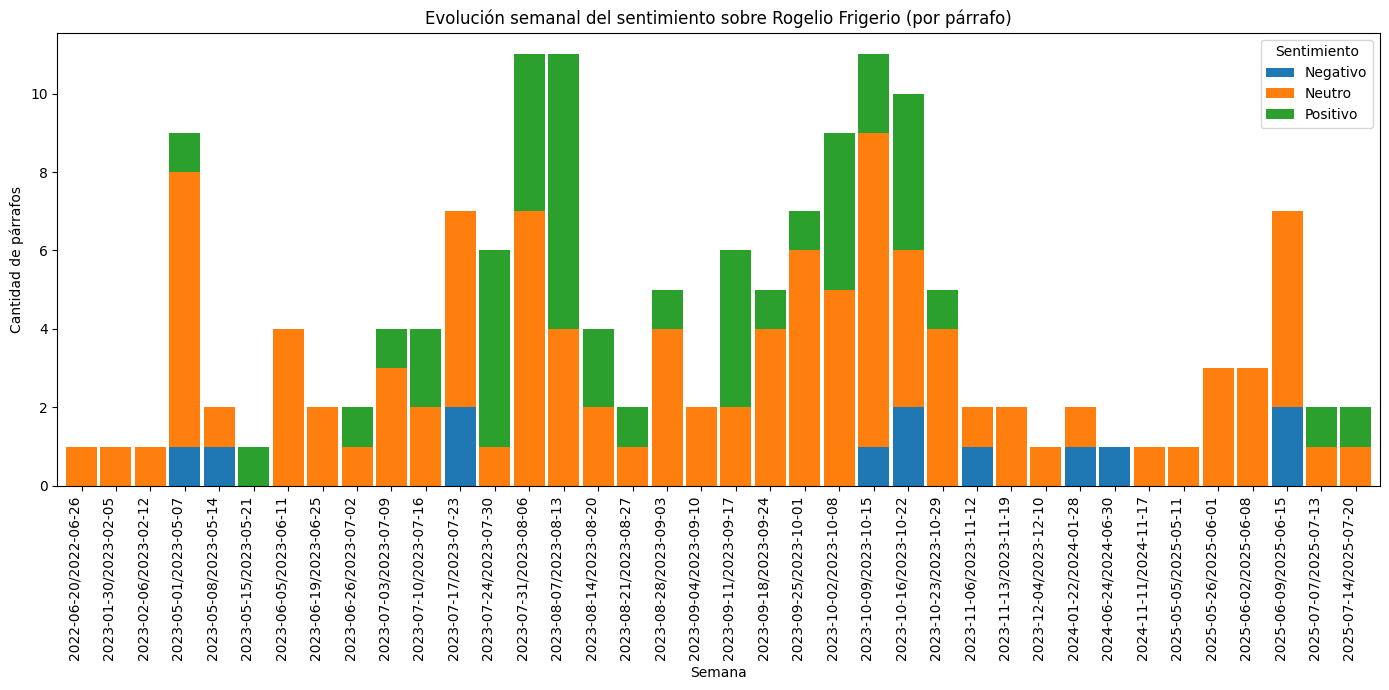

Listo: análisis por párrafo, tabla auxiliar y muestra para auditar exportadas.


In [2]:
# -- Extraccion del medio que faltaba --
import time
import pandas as pd
import os

# -- Limpieza de datos --

# Cargo e inspecciono los conjuntos de datos 
data_eldiario = pd.read_csv('../data/raw/eldiario_politica_economia_completo.csv')
data_analisis = pd.read_csv('../data/raw/analisis_provinciales_economia_completo.csv')
data_heraldo = pd.read_csv('../data/raw/noticias_heraldo_politica_economia.csv')

# Creamos columna con nombre del medio
data_eldiario['medio'] = 'eldiario'
data_analisis['medio'] = 'analisis'
data_heraldo['medio'] = 'elheraldo'

# Estandarizar columnas
data_eldiario.rename(columns={'titulo': 'titulo', 'enlace': 'enlace', 'fecha_publicacion': 'fecha', 'descripcion': 'contenido'}, inplace=True)

# Tratamiento de fechas
print('eldiario', data_eldiario['fecha'].head(3))
MESES = {
    "enero": 1, "febrero": 2, "marzo": 3, "abril": 4, "mayo": 5, "junio": 6,
    "julio": 7, "agosto": 8, "septiembre": 9, "octubre": 10, "noviembre": 11, "diciembre": 12
}
fechas_eldiario = []
for f in data_eldiario['fecha']:
    if isinstance(f, str) and ',' in f:
        partes = f.replace(',', '').lower().split()
        dia = int(partes[0])
        mes = MESES[partes[1]]
        anio = int(partes[2])
        fechas_eldiario.append(pd.Timestamp(year=anio, month=mes, day=dia))
    else:
        fechas_eldiario.append(pd.NaT)
data_eldiario['fecha'] = fechas_eldiario
print(data_eldiario['fecha'].head(3))

# Análisis: fecha tipo '20 de Julio de 2025 - 11:46'
print('analisis:', data_analisis['fecha'].head(3))
fechas_analisis = []
for f in data_analisis['fecha']:
    if isinstance(f, str) and 'de' in f and '-' in f:
        partes = f.lower().split(' - ')
        fecha_partes = partes[0].replace('de ', '').split()
        dia = int(fecha_partes[0])
        mes = MESES[fecha_partes[1]]
        anio = int(fecha_partes[2])
        hora, minuto = map(int, partes[1].split(':'))
        fechas_analisis.append(pd.Timestamp(year=anio, month=mes, day=dia, hour=hora, minute=minuto))
    else:
        fechas_analisis.append(pd.NaT)
data_analisis['fecha'] = fechas_analisis
print(data_analisis['fecha'].head(3))

# El Heraldo: fecha tipo '19 de julio de 2025 - 11:00'
print('elheraldo:', data_heraldo['fecha'].head(3))
fechas_heraldo = []
for f in data_heraldo['fecha']:
    if isinstance(f, str) and 'de' in f and '-' in f:
        partes = f.lower().split(' - ')
        fecha_partes = partes[0].replace('de ', '').split()
        dia = int(fecha_partes[0])
        mes = MESES[fecha_partes[1]]
        anio = int(fecha_partes[2])
        hora, minuto = map(int, partes[1].split(':'))
        fechas_heraldo.append(pd.Timestamp(year=anio, month=mes, day=dia, hour=hora, minute=minuto))
    else:
        fechas_heraldo.append(pd.NaT)
data_heraldo['fecha'] = fechas_heraldo
print(data_heraldo['fecha'].head(3))

# Unimos los DataFrames 
columnas_finales = ['titulo', 'descripcion', 'fecha', 'enlace', 'medio']
for df in [data_eldiario, data_analisis, data_heraldo]:
    for col in columnas_finales:
        if col not in df.columns:
            df[col] = ""
df_noticias = pd.concat([data_eldiario, data_analisis, data_heraldo], ignore_index=True)

# Unificar los textos
df_noticias["titulo"] = df_noticias["titulo"].fillna("")
df_noticias["descripcion"] = df_noticias["descripcion"].fillna("")
df_noticias["texto_completo"] = df_noticias["titulo"] + ". " + df_noticias["descripcion"]

# Limpieza básica
import re
import unicodedata

def limpiar_texto(texto):
    if pd.isnull(texto):
        return ""
    texto = texto.lower()
    texto = unicodedata.normalize("NFKD", texto).encode("ascii", "ignore").decode("utf-8")
    texto = re.sub(r'\s+', ' ', texto)
    texto = re.sub(r'[^a-zA-Z0-9áéíóúñü ]', '', texto)  # Solo letras, números y espacios
    return texto.strip()

df_noticias["texto_limpio"] = df_noticias["texto_completo"].apply(limpiar_texto)
df_noticias.to_csv('../data/processed/noticias_limpias.csv', index=False)
print("Datos limpios guardados en 'noticias_limpias.csv'")

# --- Fin del Script ---

# --- Análisis de candidatos y sentimientos ---
df = df_noticias.drop_duplicates(subset=['enlace'])

import pandas as pd
import re
import pysentimiento
import matplotlib.pyplot as plt

# --- Filtrar noticias que mencionan a Frigerio (mejorado) ---
def menciona_frigerio(texto):
    variantes = [r"adan bahl", r"\bbahl\b"]
    return any(re.search(var, texto) for var in variantes)

df['es_frigerio'] = df['texto_limpio'].apply(menciona_frigerio)
df_frigerio = df[df['es_frigerio']].copy()
print(f"Noticias que mencionan a Frigerio: {df_frigerio.shape[0]}")

# --- Inicializar el analizador de sentimiento ---
analyzer = pysentimiento.create_analyzer(task="sentiment", lang="es")

# --- Analizar sentimiento por párrafo ---
def dividir_parrafos(texto):
    return [p.strip() for p in re.split(r'[\n\r]+', texto) if len(p.strip()) > 15]

resultados = []
for idx, row in df_frigerio.iterrows():
    parrafos = dividir_parrafos(row['texto_completo'])
    for i, parrafo in enumerate(parrafos):
        resultado = analyzer.predict(str(parrafo))
        resultados.append({
            "medio": row["medio"],
            "fecha": row["fecha"],
            "titulo": row["titulo"],
            "enlace": row["enlace"],
            "nro_parrafo": i+1,
            "texto_parrafo": parrafo,
            "sentimiento": resultado.output,
            "score_pos": resultado.probas['POS'],
            "score_neg": resultado.probas['NEG'],
            "score_neu": resultado.probas['NEU'],
            "largo_parrafo": len(parrafo)
        })

df_parrafos = pd.DataFrame(resultados)

# --- Exportar muestra auditada ---
df_muestra = df_parrafos.sample(30, random_state=123)
df_muestra.to_excel('muestra_frigerio_sentimiento.xlsx', index=False)

# --- Agregados para indicadores semanales ---
df_parrafos['fecha'] = pd.to_datetime(df_parrafos['fecha'])
df_parrafos['semana'] = df_parrafos['fecha'].dt.to_period('W').astype(str)
evolucion = (
    df_parrafos.groupby(['semana', 'sentimiento'])
    .size().unstack(fill_value=0)
    .sort_index()
    .rename(columns={"POS":"Positivo", "NEG":"Negativo", "NEU":"Neutro"})
)

# --- Graficar barras apiladas ---
ax = evolucion.plot(kind='bar', stacked=True, figsize=(14,7), width=0.9)
plt.title("Evolución semanal del sentimiento sobre Rogelio Frigerio (por párrafo)")
plt.ylabel("Cantidad de párrafos")
plt.xlabel("Semana")
plt.xticks(rotation=90, ha='right')
plt.legend(title="Sentimiento")
plt.tight_layout()
plt.show()

# --- Exportar tabla completa con resultados auxiliares ---
with pd.ExcelWriter('auxiliares_frigerio_sentimiento.xlsx') as writer:
    df_parrafos.to_excel(writer, sheet_name='Parrafos_sentimiento', index=False)
    evolucion.reset_index().to_excel(writer, sheet_name='Evolucion_semanal', index=False)

print("Listo: análisis por párrafo, tabla auxiliar y muestra para auditar exportadas.")
